In [184]:
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import scipy
from scipy.special import logit
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder

## Чтение и обработка данных

In [33]:
df = pd.read_csv('../data/data.csv')

In [34]:
# парсим дату в строку вида yyyy-MM-dd
df['date_time_str'] = df['date_time'].apply(lambda x: x[:10])
# отбрасываем ненужные колонки
df = df.drop(columns=[
    'oaid_hash', 
    'rate0', 
    'rate1', 
    'impressions'  # странная фича, у которой всего одно уникальное значение, удалим
]).sort_values(by=['date_time']).reset_index(drop=True)  # сортируем по дате

# оказалось что наблюдение с такой датой - выброс
df = df[df['date_time_str'] != '2021-09-01'].reset_index(drop=True)

In [35]:
test_tmp = df[df['date_time_str'] == '2021-10-02'].reset_index(drop=True)
# подсчет пропущенных значений в нужных нам колонках для подсчета метрики clipped ips
test_tmp[['banner_id', 'banner_id0', 'banner_id1', 
          'coeff_sum0', 'coeff_sum1', 'g0', 'g1']].isnull().sum()

banner_id        0
banner_id0       0
banner_id1       0
coeff_sum0      12
coeff_sum1    4904
g0              12
g1            4904
dtype: int64

Есть пропуски в coeff_sum0, coeff_sum0, g0, g1 - удалим наблюдения с пропуками.

In [36]:
indices = test_tmp[['banner_id', 'banner_id0', 'banner_id1', 
          'coeff_sum0', 'coeff_sum1', 'g0', 'g1']].isnull().sum(axis=1)
test_tmp = test_tmp[~test_tmp.index.isin(indices[indices > 0].index.tolist())].reset_index(drop=True)
test_tmp[['banner_id', 'banner_id0', 'banner_id1', 
          'coeff_sum0', 'coeff_sum1', 'g0', 'g1']].isnull().sum()

banner_id     0
banner_id0    0
banner_id1    0
coeff_sum0    0
coeff_sum1    0
g0            0
g1            0
dtype: int64

В условии задачи было сказано: "banner_id0 совпадает почти всегда совпадает с banner_id, но есть случаи когда это не так, их стоит отфильтровать.". Проверим такие случаи, если они есть - отфильтруем.

In [37]:
# такие случаи есть
test_tmp[test_tmp['banner_id'] != test_tmp['banner_id0']].shape[0]

238404

In [38]:
test_tmp = test_tmp[test_tmp['banner_id'] == test_tmp['banner_id0']].reset_index(drop=True)

Махинации с тем, чтобы сделать одновременное преобразование фичей в трейне и двух тестах.

In [39]:
def concat_train_and_two_types_of_test(train, test_tmp):
    train['status_of_dataset'] = 'train'
    test_0 = test_tmp.copy()
    test_1 = test_tmp.copy()
    test_0['status_of_dataset'] = 'test_with_banner_id_as_banner_id0'
    test_1['status_of_dataset'] = 'test_with_banner_id_as_banner_id1'
    test_1['banner_id'] = test_1['banner_id1']
    return pd.concat([train, test_0, test_1], axis=0).reset_index(drop=True)

In [40]:
train = df[df['date_time_str'] < '2021-10-02']
df = concat_train_and_two_types_of_test(train, test_tmp)

In [41]:
del train
del test_tmp

Функции для трансформации фичей из первой домашки.

In [42]:
def feature_transforming(df: pd.DataFrame) -> pd.DataFrame:
    """
    This function creates new columns in dataframe related
    somehow to date time of observation: it gets
    month number, week number, day week number, 
    day week status (working day/weekend), hour number, 
    minute number and second number.
    """
    # трансформируем строку в пандасовскую дату
    df['date_time'] = pd.to_datetime(df['date_time'])
    # вытаскиваем различные полезные фичи из полной даты каждого наблюдения:
    # получаем номер месяца наблюдения
    df['month_num'] = df['date_time'].apply(lambda x: x.month)
    # получаем номер недели наблюдения
    df['week_num'] = df['date_time'].apply(lambda x: x.week)
    # получаем номер дня недели наблюдения
    df['day_week_num'] = df['date_time'].apply(lambda x: x.dayofweek)
    # получаем информацию о дне наблюдения - выходной или рабочий день
    df['day_week_status'] = df['day_week_num'].apply(
        lambda x: 'working day' if 1 <= x <= 5 else 'weekend day'
    )
    # получаем номер часа наблюдения
    df['hour_num'] = df['date_time'].apply(lambda x: x.hour)
    # получаем номер минуты наблюдения
    df['minute_num'] = df['date_time'].apply(lambda x: x.minute)
    # получаем номер секунды наблюдения
    df['second_num'] = df['date_time'].apply(lambda x: x.second)
    # отбрасываем колонку с пандасовской датой
    df.drop(columns=['date_time'], inplace=True)
    return df

In [43]:
def feature_engineering(df: pd.DataFrame) -> (scipy.sparse.csr.csr_matrix, np.ndarray):
    """
    This function creates new different noninterpreted features 
    based on logic of interactions of user, of date, of day and then 
    transforms it to very big sparse matrix using OneHotEncoder.
    """
    from itertools import combinations  # пригодится
    
    # разбиваем фичи на три группы: пользовательские (айдишник ОСи, города и т.д.),
    # календарной даты (месяц, неделя, день, выходной/рабочий) и 
    # дневной даты (час, минута, секунда)
    features_user = ['zone_id', 'banner_id', 'campaign_clicks', 'os_id', 'country_id']
    features_date = ['month_num', 'week_num', 'day_week_num', 'day_week_status']
    features_day = ['hour_num', 'minute_num', 'second_num']
    
    # функция получения всех подмножеств заданного размера данного множества
    def subsets_size_n(set_of_elements, n_size):
        return list(set(combinations(set_of_elements, n_size)))
    
    subsets = []
    # получаем все попарные признаки для создания 
    # интеракций для каждой группы фичей
    for feature in [features_user, features_date, features_day]:
        subsets += subsets_size_n(feature, 2) 
    
    # создаем интеракции, джойня строки
    for subset in tqdm(subsets):
        new_feature_name = " & ".join(subset)
        new_feature_values = np.apply_along_axis(
            ''.join, 
            axis=1, 
            arr=df.loc[:, subset].values.astype(str)
        )
        df[new_feature_name] = new_feature_values
    
    # кодируем OneHotEncoder'ом все предикторы и получаем массив откликов
    X, y = OneHotEncoder().fit_transform(df.drop(columns=['clicks'])), df['clicks'].values
    return X, y

Генерируем различные фичи и крафтим интерации.

In [47]:
df_tmp = feature_transforming(df[['date_time', 'zone_id', 'banner_id', 'campaign_clicks', 'os_id',
   'country_id', 'clicks']])

In [48]:
X, y = feature_engineering(df_tmp)

100%|██████████████████████████████████████████| 19/19 [40:03<00:00, 126.51s/it]


Разделяем на трейн и два теста.

In [50]:
def train_two_tests_split(X, y, df):
    train_indices = df[df['status_of_dataset'] == 'train'].index.tolist()
    test_0_indices = df[df['status_of_dataset'] == 'test_with_banner_id_as_banner_id0'].index.tolist()
    test_1_indices = df[df['status_of_dataset'] == 'test_with_banner_id_as_banner_id1'].index.tolist()
    return (
        X[train_indices], y[train_indices],
        X[test_0_indices], y[test_0_indices],
        X[test_1_indices], y[test_1_indices]
    )

In [51]:
train_test_split = train_two_tests_split(X, y, df)
X_train, y_train = train_test_split[0], train_test_split[1]
X_test_0, y_test_0 = train_test_split[2], train_test_split[3]
X_test_1, y_test_1 = train_test_split[4], train_test_split[5]

In [52]:
del train_test_split

## Модель из 1 домашки

In [55]:
def create_model(X_train, y_train, C=0.0001):
    """
    This function trains model on best parameters found by
    cross validation on union of train and validation sets.
    """
    clf = LogisticRegression(random_state=54, C=C, n_jobs=-1)
    clf.fit(X_train, y_train)
    return clf

In [57]:
%%time
model = create_model(X_train, y_train, C=0.0001)

CPU times: user 2.11 s, sys: 3.94 s, total: 6.05 s
Wall time: 2min 29s


## Расчет метрики clipped ips на последнем дне

In [161]:
test_df = df[
    (df['date_time_str'] == '2021-10-02') & 
    (df['status_of_dataset'] == 'test_with_banner_id_as_banner_id0')
].reset_index(drop=True)[['banner_id0', 'banner_id1', 'g0', 'g1', 'coeff_sum0', 'coeff_sum1', 'clicks']]

In [162]:
test_df['coeff_sum0_new'] = logit(model.predict_proba(X_test_0)[:, 0])
test_df['coeff_sum1_new'] = logit(model.predict_proba(X_test_1)[:, 0])

In [163]:
# есть кейсы когда g0 и g1 равны нулю - кажется что такое не ок, 
# давайте просто уберем их (если не убирать, то у меня вылезали nan'ы)
test_df[(test_df['g0'] == 0) & (test_df['g1'] == 0)]
test_df = test_df[~((test_df['g0'] == 0) & (test_df['g1'] == 0))].reset_index(drop=True)

Вводная инфа о том как считались pi1 и pi0.

У нас есть две независимые нормальные случайные величины
$$X \sim N(a_1, b_1^2),  \;\; Y \sim N(a_1, b_1^2)$$
Из теорвера знаем, что разность этих случайных величин имеет распределение
$$X - Y \sim N(a_1 - a_2, b_1^2 + b_2^2)$$
Тогда можем найти вероятность того, что одна нормальная случайная величина больше другой:
$$P(X < Y) = P(X - Y < 0) = F_{X - Y}(0)= Ф\left(\dfrac{0 - (a_1 - a_2)}{\sqrt{b_1^2 + b_2^2}}\right) = Ф\left(\dfrac{a_2 - a_1}{\sqrt{b_1^2 + b_2^2}}\right)$$

In [164]:
def calculate_probability(a_1, b_1, a_2, b_2):
    # X ~ N(a_1, b_1^2), Y ~ N(a_2, b_2^2) -> P(X < Y) = ?
    loc = a_1 - a_2
    scale = np.sqrt(b_1 ** 2 + b_2 ** 2)
    x = 0
    y = (x - loc) / scale
    return norm.cdf(y)

Почему-то очень долго вычислялись полиси через метод `apply`, поэтому заюзал обычный цикл для вычисления pi0 и pi1.

In [180]:
def calculate_policies(df):
    pi0 = []
    for row in df[['coeff_sum0', 'coeff_sum1', 'g0', 'g1']].values:
        coeff_sum0, coeff_sum1, g0, g1 = row
        pi0.append(calculate_probability(coeff_sum0, g0, coeff_sum1, g1))

    pi1 = []
    for row in df[['coeff_sum0_new', 'coeff_sum1_new', 'g0', 'g1']].values:
        coeff_sum0, coeff_sum1, g0, g1 = row
        pi1.append(calculate_probability(coeff_sum0, g0, coeff_sum1, g1))
    return np.array(pi0), np.array(pi1)

def calculate_metric_clipped_ips(rewards, pi0, pi1, l):
    ratio = pi1/pi0
    return np.mean(np.minimum(l, ratio[~np.isnan(ratio)]) * rewards[~np.isnan(ratio)])

def calculate_clipped_ips_for_df(df, l=10):
    pi0, pi1 = calculate_policies(df)
    rewards = df['clicks'].to_numpy()
    return calculate_metric_clipped_ips(rewards, pi0, pi1, l)

In [166]:
# значение метрики clipped ips на последнем дне
calculate_clipped_ips_for_df(test_df, l=10)

100%|██████████████████████████████| 1885598/1885598 [03:02<00:00, 10317.11it/s]


0.20044470418327728

In [152]:
test_df['clicks'].value_counts(normalize=True)

0    0.963955
1    0.036045
Name: clicks, dtype: float64

Значение метрики clipped ips почти в 6 раз больше CTR - в чате было сказано, что такие случаи в целом ок, плюс кажется, что сыграло роль то, что метрика clipped ips является смещенной. 

Теперь хочется посмотреть, что будет для других параметров регуляризации.

Соединим все в одну функцию, чтобы попробовать найти оптимальную регуляризацию по метрике cips.

In [167]:
def calculate_clipped_ips_on_test(model, X_test_0, X_test_1, df):
    test_df = df[
        (df['date_time_str'] == '2021-10-02') & 
        (df['status_of_dataset'] == 'test_with_banner_id_as_banner_id0')
    ].reset_index(drop=True)[['banner_id0', 'banner_id1', 'g0', 'g1', 'coeff_sum0', 'coeff_sum1', 'clicks']]
    test_df['coeff_sum0_new'] = logit(model.predict_proba(X_test_0)[:, 0])
    test_df['coeff_sum1_new'] = logit(model.predict_proba(X_test_1)[:, 0])
    # есть кейсы когда g0 и g1 равны нулю - кажется что такое не ок, давайте просто уберем их
    test_df[(test_df['g0'] == 0) & (test_df['g1'] == 0)]
    test_df = test_df[~((test_df['g0'] == 0) & (test_df['g1'] == 0))].reset_index(drop=True)
    return calculate_clipped_ips_for_df(test_df, l=10)

In [168]:
calculate_clipped_ips_on_test(model, X_test_0, X_test_1, df)

100%|██████████████████████████████| 1885598/1885598 [03:00<00:00, 10473.75it/s]


0.20044470418327728

In [186]:
c = np.linspace(0.1, 2, 10)
metric = []
log_losses = []
for c_i in tqdm(c):
    cur_model = create_model(X_train, y_train, C=c_i)
    print('======'*5)
    print(f'Regularization parameter c = {c_i:.2f}')
    cur_metric = calculate_clipped_ips_on_test(cur_model, X_test_0, X_test_1, df)
    metric.append(cur_metric)
    cur_log_loss = log_loss(
            y_test_0, 
            cur_model.predict_proba(X_test_0)
        )
    log_losses.append(cur_log_loss)
    print(f'Metric clipped ips on last day: {cur_metric:.4f}')
    print(f'Logloss on last day: {cur_log_loss:.4f}')

  0%|                                                    | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Regularization parameter c = 0.10


 10%|████                                     | 1/10 [08:00<1:12:03, 480.44s/it]

Metric clipped ips on last day: 0.1952
Logloss on last day: 0.1388


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Regularization parameter c = 0.31


 20%|████████▏                                | 2/10 [15:56<1:03:42, 477.76s/it]

Metric clipped ips on last day: 0.1960
Logloss on last day: 0.1389


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Regularization parameter c = 0.52


 30%|████████████▉                              | 3/10 [23:56<55:51, 478.81s/it]

Metric clipped ips on last day: 0.1962
Logloss on last day: 0.1393


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Regularization parameter c = 0.73


 40%|█████████████████▏                         | 4/10 [31:46<47:33, 475.57s/it]

Metric clipped ips on last day: 0.1958
Logloss on last day: 0.1393


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Regularization parameter c = 0.94


 50%|█████████████████████▌                     | 5/10 [39:49<39:50, 478.15s/it]

Metric clipped ips on last day: 0.1952
Logloss on last day: 0.1392


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Regularization parameter c = 1.16


 60%|█████████████████████████▊                 | 6/10 [47:41<31:43, 475.92s/it]

Metric clipped ips on last day: 0.1962
Logloss on last day: 0.1391


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Regularization parameter c = 1.37


 70%|██████████████████████████████             | 7/10 [55:41<23:52, 477.36s/it]

Metric clipped ips on last day: 0.1970
Logloss on last day: 0.1389


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Regularization parameter c = 1.58


 80%|████████████████████████████████▊        | 8/10 [1:03:37<15:53, 476.95s/it]

Metric clipped ips on last day: 0.1960
Logloss on last day: 0.1392


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Regularization parameter c = 1.79


 90%|████████████████████████████████████▉    | 9/10 [1:11:31<07:56, 476.12s/it]

Metric clipped ips on last day: 0.1969
Logloss on last day: 0.1390


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Regularization parameter c = 2.00


100%|████████████████████████████████████████| 10/10 [1:19:36<00:00, 477.61s/it]

Metric clipped ips on last day: 0.1963
Logloss on last day: 0.1389


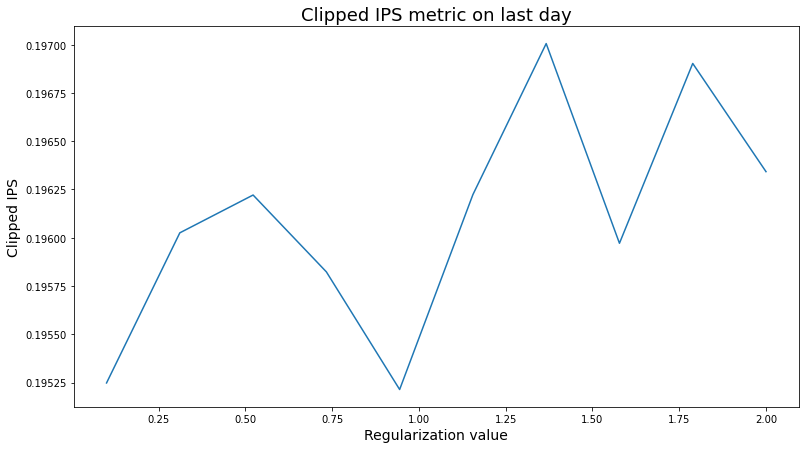

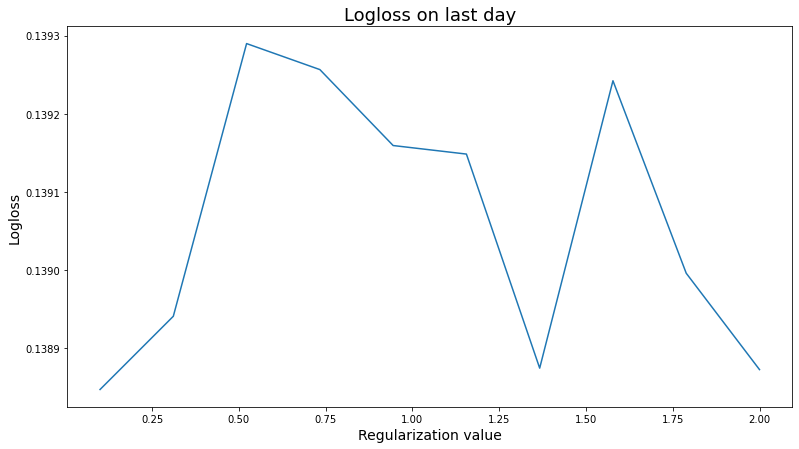

In [192]:
plt.figure(figsize=(13, 7))
plt.plot(c, metric)
plt.title('Clipped IPS metric on last day', size=18)
plt.xlabel('Regularization value', size=14)
plt.ylabel('Clipped IPS', size=14)
plt.figure(figsize=(13, 7))
plt.plot(c, log_losses)
plt.title('Logloss on last day', size=18)
plt.xlabel('Regularization value', size=14)
plt.ylabel('Logloss', size=14);

In [198]:
tmp = pd.DataFrame([c, metric, log_losses]).T
tmp.columns = ['regularization_parameter', 'clipped_ips', 'log_loss']
tmp

,regularization_parameter,clipped_ips,log_loss
0,0.100000,0.195248,0.138846
1,0.311111,0.196025,0.138940
2,0.522222,0.196221,0.139290
3,0.733333,0.195823,0.139256
4,0.944444,0.195214,0.139159
5,1.155556,0.196223,0.139148
6,1.366667,0.197006,0.138874
7,1.577778,0.195971,0.139242
8,1.788889,0.196903,0.138995
9,2.000000,0.196342,0.138872


Таким образом, лучший параметр регулярищации модели по оптимизации метрики clipped ips на последнем дне оказался равен 1.577 (`clipped_ips=0.197`). Который оказался меньше значения метрики clipped ips на изначальном параметре регуляризации `c=0.00001`, который дал значение метрики `clipped_ips=0.2004`, поэтому, можно сказать, что в первой домашке параметр регуляризации был выбран правильно.

_Выводы_:
1. В рамках данной домашней работе научились считать cips
2. Значение cips оказалось раз в 5-6 больше ctr - в чате было сказано, что это норм ситуация: я думаю, что тут сыграло то, что метрика cips смещена, и то что часть данных из последнего дня я удалил - например, из за пропусков и/или нулевого значения g0 (g1), а также из-за того, что я крафтил много фичей и много интеракций
3. Подобрали параметр регуляризации, оптимизируя метрику cips - оказалось так, что на просматриваемом наборе параметров по cips лучший параметр регуляризации ровно тот, который был выбран в первой домашке